## Imports

7 files were processed and added to the 'text-files' folder.


100%|██████████| 7/7 [00:00<00:00,  9.48it/s]


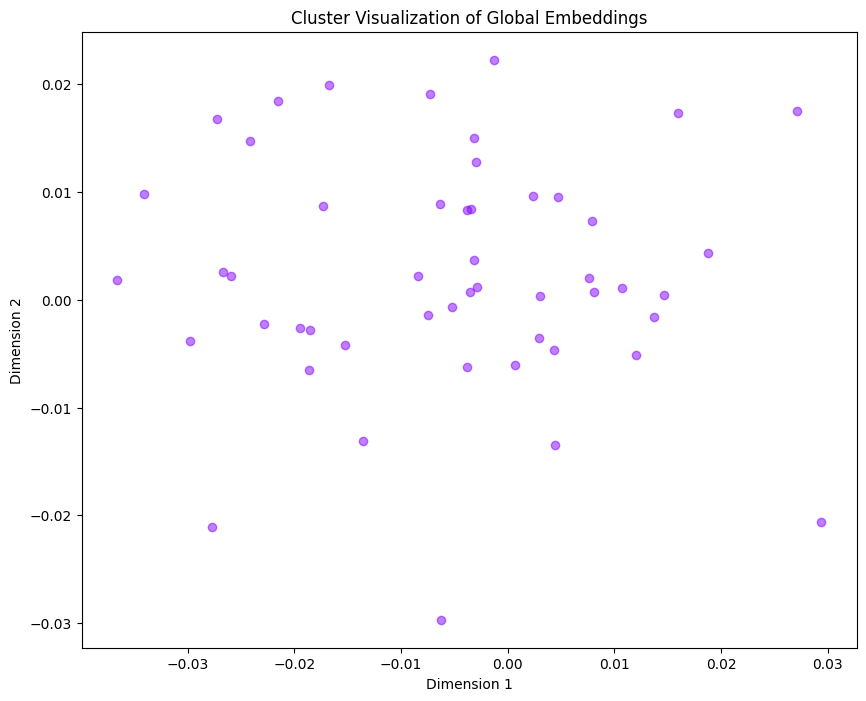

AttributeError: 'Node' object has no attribute 'children'

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from utils import create_nodes_from_documents, summarize_clusters, visualize_clusters, cluster_nodes, markdown_to_text
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.mixture import GaussianMixture


class Config:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500, chunk_overlap=75, length_function=len, is_separator_regex=False)
        self.source_folder = 'knowledge-vault/nodes'
        self.destination_folder = 'text-files'
        self.phrases_to_remove = ["video links", "Video Links",
                                  "Second Brain", "brain dump", "Brain Dump", "upstream"]
        self.chunk_size = 500
        self.chunk_overlap = 75
        self.model_temperature = 0
        self.model_name = "gpt-3.5-turbo"
        self.embedding_dim = 2
        self.max_clusters = 50
        self.random_state = 1234
        self.cluster_threshold = 0.5
        self.summary_template = """You are an assistant to create a summary of the text input provided. It should be human-readable. It should contain a minimum of 1 word and a maximum of 4 words
        Text:
        {text}
        """
        self.recursive_depth = 3
        self.cluster_method = 'GMM'


class Node:
    def __init__(self, text, embedding, depth):
        self.text = text
        self.embedding = embedding
        self.depth = depth
        self.children = []


def create_recursive_tree(nodes, config, embedding_model, model, depth=0):
    if depth >= config.recursive_depth:
        return nodes

    embeddings = [node.embedding for node in nodes]
    gmm = GaussianMixture(n_components=min(
        config.max_clusters, len(nodes)), random_state=config.random_state)
    clusters = gmm.fit_predict(embeddings)

    clustered_nodes = {}
    for cluster_id in set(clusters):
        clustered_nodes[cluster_id] = []

    for i, cluster_id in enumerate(clusters):
        clustered_nodes[cluster_id].append(nodes[i])

    for cluster_id, cluster_nodes in clustered_nodes.items():
        if len(cluster_nodes) > 1:
            summary = summarize_clusters(pd.DataFrame({
                'Text': [node.text for node in cluster_nodes],
                'Embedding': [node.embedding for node in cluster_nodes],
                'Cluster': [cluster_id] * len(cluster_nodes)
            }), model, config.summary_template)
            parent_node = create_node(
                summary[cluster_id], config, embedding_model, depth + 1)
            parent_node.children = create_recursive_tree(
                cluster_nodes, config, embedding_model, model, depth + 1)
            clustered_nodes[cluster_id] = [parent_node]
        else:
            clustered_nodes[cluster_id] = cluster_nodes

    return [node for nodes in clustered_nodes.values() for node in nodes]


def create_node(text, config, embedding_model, depth):
    embedding = embedding_model.embed_query(text)
    return Node(text=text, embedding=embedding, depth=depth)


class CustomRAPTORAgent:
    def __init__(self, tree, model, embedding_model, config):
        self.tree = tree
        self.model = model
        self.embedding_model = embedding_model
        self.config = config

    def query_tree(self, query):
        relevant_nodes = self.retrieve_relevant_nodes(query, self.tree)
        summarized_response = self.summarize_response(relevant_nodes)
        return summarized_response

    def retrieve_relevant_nodes(self, query, nodes):
        query_embedding = self.embedding_model.embed_query(query)
        relevant_nodes = []

        def traverse_and_collect(node):
            similarity = cosine_similarity(
                [query_embedding], [node.embedding])[0][0]
            if similarity > self.config.cluster_threshold:
                relevant_nodes.append((node, similarity))
            for child in node.children:
                traverse_and_collect(child)

        for node in nodes:
            traverse_and_collect(node)

        relevant_nodes.sort(key=lambda x: x[1], reverse=True)
        return [node for node, similarity in relevant_nodes[:self.config.max_clusters]]

    def summarize_response(self, nodes):
        texts = [node.text for node in nodes]
        combined_text = " ".join(texts)
        prompt = self.config.summary_template.format(text=combined_text)
        # Adjusted for correct usage
        summary = self.model(prompt).choices[0].text.strip()
        return summary


config = Config()
markdown_to_text(config.source_folder,
                 config.destination_folder, config.phrases_to_remove)
embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=config.model_temperature,
                   model=config.model_name)
nodes = create_nodes_from_documents(
    config.destination_folder, embedding_model, config)
tree = create_recursive_tree(nodes, config, embedding_model, model)
visualize_clusters(pd.DataFrame({
    'Text': [node.text for node in tree],
    'Embedding': [node.embedding for node in tree],
    # Assuming all nodes are part of one cluster for visualization
    'Cluster': [0] * len(tree)
}))
summaries = summarize_clusters(pd.DataFrame({
    'Text': [node.text for node in tree],
    'Embedding': [node.embedding for node in tree],
    'Cluster': [0] * len(tree)
}), model, config.summary_template)

agent = CustomRAPTORAgent(tree, model, embedding_model, config)
response = agent.query_tree("Your query here")
print(response)